# Introduction: Manual Feature Engineering

이 노트북에서는 직접 피처를 만드는 방법에 대해 알아봅니다. 

이전 노트북에서는 모델을 구축하기 위해 application 데이터만 사용했습니다. 이 모델은 약 0.74의 점수를 얻었습니다. 점수를 더 받기 위해서는 다른 데이터프레임의 정보를 더 포함해야 합니다. 여기서는 bureau 및 bureau_balance 데이터의 활용에 대해 알아보겠습니다.

bureau: 고객이 이전에 다른 금융 기관에서 대출한 내용입니다. 이 대출은 각각 고유한 행이 있습니다.

bureau_balance: 이전 대출에 대한 월별 정보입니다. 매 월은 자체 행이 있습니다.
수동 피처 엔지니어링은 지루한 프로세스일 수 있으며 종종 도메인 전문지식에 의존합니다. 대출에 대해 제한된 도메인 지식을 가지고 있기 때문에, 가능한 한 많은 정보를 모을 것입니다. 따라서 모델은 우리가 직접 결정하는 것 보다 어떤 피처가 중요한지 알게 될 것입니다. 

기본적으로, 우리의 접근 방식은 가능한 많은 피처를 만든 다음 사용할 모델에 모든 피처를 제공하는 것입니다. 나중에 모델의 피처 중요도 또는 PCA와 같은 기술을 사용하여 기능 축소를 수행할 수 있습니다.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## Example: Counts of a client's previous loan
수동 피처 엔지니어링의 일반적인 프로세스를 설명하기 위해 먼저 다른 금융 기관에서 고객의 이전 대출 수를 파악할 수 있습니다. 

- groupby: 데이터프레임을 열 별로 그룹화합니다. 이 경우 고유한 고객인 SK_ID_CURR를 기준으로 그룹화합니다.
- agg: 열의 평균을 구하는 것과 같이 그룹화된 데이터에 대해 계산을 수행합니다. 함수를 직접 호출하거나(grouped_df.mean()) 변환 목록과 함께 agg 함수를 사용할 수 있습니다.(grouped_df.agg([mean,max,min,sum])
- merge: 집계된 통계를 적절한 고객과 일치시킵니다. 원래 트레이닝 데이터를 SK_ID_CURR의 계산된 통계와 병합해야 합니다. SK_ID_CURR에 상응하는 값이 없다면 널 값을 삽입합니다.

또한 딕셔너리로 이름을 바꿀 열을 지정하는 기능도 상당히 많이 사용합니다.

In [3]:
# Read in bureau
bureau = pd.read_csv('./input/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby("SK_ID_CURR", as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [5]:
# Join to the training dataframe
train = pd.read_csv('./input/application_train.csv')
train = train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')

# Fill the missing values with 0
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Assesing Usefulness of New Variable with r value
새 변수가 유용한지 여부를 확인하기 위해 타겟 사이의 상관계수를 계산할 수 있습니다. 이 값은 두 변수 사이의 선형 관계의 강도를 측정하고 -1에서 +1까지의 범위를 측정합니다. r값은 새 변수의 유용도에 대한 최선의 척도는 아니지만 변수가 머신러닝 모델에 도움이 될지 여부에 대한 첫 번째 근사치를 제공할 수 있습니다. 타겟에 대한 변수의 r 값이 클 수록 더 많은 영향을 미칠 수 있습니다.

또한 KDE 그림을 사용하여 타겟과의 관계를 시각적으로 검사할 수도 있습니다.

### Kernel Density Estimate Plots
커널 밀도 추정치 그림에는 단일 변수의 분포가 표시됩니다. 범주형 변수의 값에 따라 분포의 차이를 확인하려면 범주에 따라 분포의 색을 다르게 지정할 수 있습니다. 예를 들어 , 타겟이 1인지 0인지에 따라 색상이 지정된 previous_loan_count의 커널 밀도 추정치를 표시할 수 있습니다. 

In [10]:
# Plots the distribution of a variable colored by value of the target
def kde_target(var_name, df):
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize= (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' % var_name)
    plt.legend()
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid = %0.4f' % avg_repaid)
    

랜덤 포레스트 및 gbm에 따라 가장 중요한 변수 중 하나로 밝혀진 EXT_SOURCE3 변수를 사용하여 함수를 테스트 해보겠습니다.

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid = 0.5460


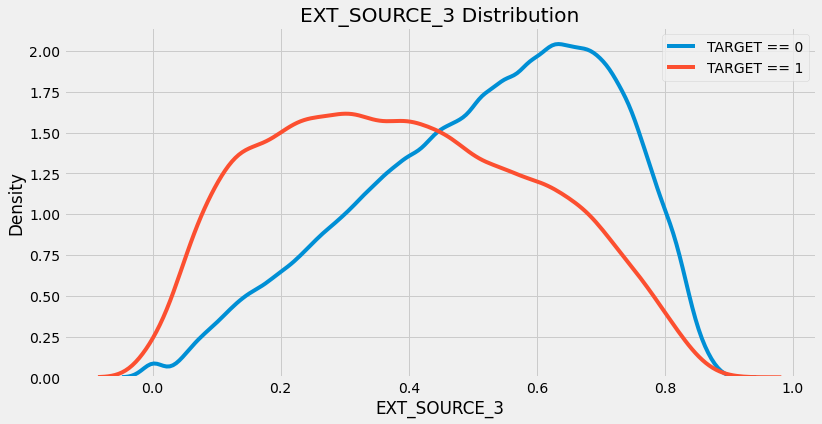

In [11]:
kde_target('EXT_SOURCE_3', train)

새로 만든 변수에 대해서도 테스트하겠습니다.

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid = 4.0000


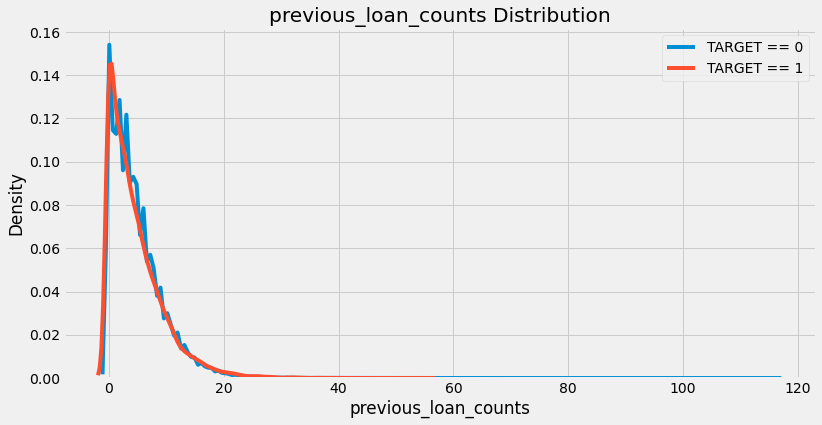

In [12]:
kde_target('previous_loan_counts', train)

이 변수로는 중요한지 여부를 알 수 없습니다. 상관 계수가 매우 약하고 분포에서 눈에 띄는 차이가 없습니다.

이제 bureau 데이터 프레임에서 몇 가지 변수를 더 만들어 보겠습니다. bureau 데이터 프레임에 있는 모든 숫자 열의 평균, 최소 및 최대값을 가져옵니다.

## Aggregating Numeric Columns
bureau 데이터 프레임의 숫자 정보를 설명하기 위해 통계를 계산할 수 있습니다. 이를 위해 고객 ID별 그룹화 및 트레이닝 데이터에 다시 병합합니다. agg 함수는 연산이 유효한 숫자열의 값만 계산합니다.

In [13]:
# Group by the client id, calculate aggreagtion statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index=False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

각 열에 대한 새 이름을 만들겠습니다. 다음 코드는 이름에 stat을 추가하여 새 이름을 만듭니다. 데이터프레임에 다중 레벨 인덱스가 있기 때문에 단일 라벨 인덱스로 줄이겠습니다.

In [14]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [15]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


전에 했던 것처럼 트레이닝 데이터에 병합하겠습니다.

In [16]:
# Merge with the training data
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### Correlations of Aggregated Values with Target
새 값들의 상관 관계를 계산하겠습니다. 이러한 변수를 모형에 중요한 변수의 근사치로 사용할 수 있습니다.

In [18]:
# List of new correlations
new_corrs = []

# Iterate through the columns
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # Append the list as a tuple
    
    new_corrs.append((col, corr))

상관 관계를 크기별로 정렬하겠습니다. 이때 lambda 함수를 사용하겠습니다.

In [19]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the fron of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse=True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998985),
 ('bureau_DAYS_CREDIT_min', 0.07524825103011096),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266969323),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984391145),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102582),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585757731),
 ('bureau_DAYS_CREDIT_max', 0.049782054639978035),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111991),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433484625),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073441),
 ('bureau_DAYS_CREDIT_sum', 0.0419998248148508),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306417),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696337574),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.03428110992162412),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332852)]

어떤 새 변수도 유의한 상관 관계를 갖지 않습니다. KDE 그림도 살펴보겠습니다. bureau_DAYS_CREDIT_mean, 절대값의 측면에서 타겟과 비교하겠습니다.

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid = -1067.0000


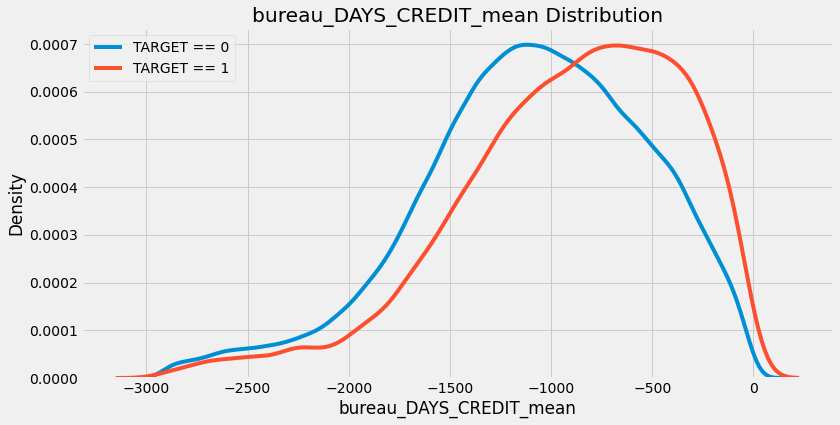

In [20]:
kde_target('bureau_DAYS_CREDIT_mean', train)

이 열의 정의는 '이전 대출을 현재 대출 전에 신청한 일 수' 입니다. 따라서 마이너스 수치가 크면 대출이 현재 대출 신청보다 더 이전임을 나타냅니다. 우리는 이 변수의 평균과 타겟 사이에 매우 약한 양의 상관관계가 있다고 봅니다. 이는 과거에 대출을 신청했던 고객들이 잠재적으로 대출을 상환할 가능성이 더 높다는 것을 의미합니다. 하지만 이렇게 약한 상관 관계에서는 노이즈일 가능성이 높습니다.

#### The Multiple Comparisons Problem
변수가 많을 때 일부 변수는 단순한 우연에 의해 상관 관계가 있을 것으로 예상합니다. 다중 비교로 알려진 문제입니다. 우리는 수백 가지의 피처를 만들 수 있고, 일부는 단순히 데이터의 무작위 노이즈 때문에 타겟과 상관관계가 있는 것으로 밝혀질 것입니다. 그 다음, 모델이 훈련할 떄 이러한 변수가 훈련 세트의 타겟과 관계가 있다고 생각하기 때문에 이러한 변수에 지나치게 적합할 수 있지만, 이것이 반드시 테스트 세트에 일반화 될 필요는 없습니다. 특징을 만들 때 고려해야 할 많은 것이 있습니다. 

## Function for Numeric Aggregations
이전의 모든 작업을 함수로 캡슐화하겠습니다. 이를 통해 모든 데이터프레임에서 숫자 열에 대한 집계 통계를 계산할 수 있습니다.

In [21]:
def agg_numeric(df, group_var, df_name):
    """데이터 프레임의 모든 숫자 값을 집계함. 그룹화 변수의 각 인스턴스에 대한 피        처를 작성하는 데 사용됩니다.
    
    Parameters
    ----------
        df (dataframe):
            계산에 사용될 데이터프레임
        group_var (string):
            그룹화 할 변수
        df_name (string):
            열의 이름 재정의할 변수
    
    Return
    ----------
        agg (dataframe):
            모든 숫자형 열에 대한 통계가 집계된 데이터프레임.
            그룹화 된 변수의 각 인스턴스는 통계정보를 포함함.
            이름 재정의는 추후 진행 예정
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns=col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
    # Need to create new column names
    columns = [group_var]
    
    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the groupiong variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
        
    agg.columns = columns
    return agg

In [22]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = "SK_ID_CURR", df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


이 함수를 다른 데이터 프레임에 대한 숫자통계를 계산하는 데 재사용할 수 있을 것입니다. 함수를 사용하면 일관된 결과를 얻을 수 있고 해야할 일의 양을 줄일 수 있습니다.

### Correlation Function
타겟과의 상관관계를 계산하는 코드를 함수로 만들 수도 있습니다.

In [23]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):
    
    # List of correlations
    corrs = []
    
    # Iterate through the columns
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])
            
            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse=True)
    
    return corrs